# CIFA-10 dataset 
Door Gerrit van de Bunt, 1756708, 2020-2021

# Stap 0
Tool collection, verzamel alle benodigde tools.

In [1]:
import tensorflow as tf 
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from tensorflow.keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, Conv3D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, BatchNormalization # Verschillende type lagen die we gaan gebruiken
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras.regularizers import L1, L2, l1_l2
from tensorflow.keras import utils        # NumPy gerelateerde tools

import tensorflow.keras.datasets.cifar10  # Target dataset

# Stap 1 - Data collection
Haal de benodigde data op, in dit geval de cifar-10 dataset uit tensorflow, en doe een kleine analyse over de data (vooral bedoeld om de integriteit te achterhalen)

In [2]:
(X_train, Y_train), (X_test, Y_test) = tensorflow.keras.datasets.cifar10.load_data()

Text(0.5, 1.0, 'Class: [7]')

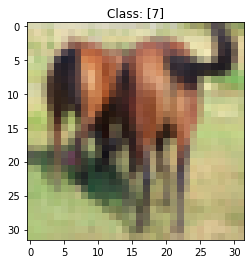

In [3]:
# Deze cel laat een willekeurige foto zien en de bijbehorende klasse.
randomindex = random.randint(0,len(X_train))
plt.imshow(X_train[randomindex])
plt.title("Class: {}".format(Y_train[randomindex]))

Class dictionary:

0 = Airplane\
1 = Automobile\
2 = Bird\
3 = Cats\
4 = Deer\
5 = Dog\
6 = Frog\
7 = Horse\
8 = Ship\
9 = Truck

# Stap 2 - Data preparation
Het doel is om uiteindelijk eerst met een convolutionair netwerk te beginnen en dan over te gaan in een normaal neuraal netwerk. Hier komt nog wel het een en ander bij kijken; we zullen rekening moeten houden met hoe we onze data invoeren. In dit geval is de data precies zoals we die willen, en Keras regelt de overgang tussen de shapes zodra we de convolutionary layers gaan aanroepen, maar voor de zekerheid gaan we alsnog de data converteren.

In [4]:
# Eerst achterhalen wat de shape is van de X-bestanden
X_train[0].shape
print(X_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


We hebben met elk exemplaar te maken met pixels (32x32), met daarin nog eens 3 kleuren (R,G,B).

In [5]:
print(X_train.shape)

(50000, 32, 32, 3)


In [6]:
X_train = X_train.reshape(50000,32,32,3)
X_test = X_test.reshape(10000,32,32,3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255                              
X_test /= 255

Uiteindelijk hebben we dan 50000 exemplaren.

In [7]:
print(Y_train[0].shape)
print(Y_train[0])
print(Y_train.shape)

(1,)
[6]
(50000, 1)


Tenslotte hebben we 50000 enkele lijsten voor de klasse van een object. Deze zullen we wel moeten omvormen naar een "dummy" list, omdat elke output van ons netwerk voor een klasse staat.

In [8]:
classes = len(np.unique(Y_train))

Y_train_labels = Y_train
Y_test_labels = Y_test

Y_train = utils.to_categorical(Y_train, classes)
Y_test = utils.to_categorical(Y_test, classes)

Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Onze data is nu georganiseerd. Verder willen we nog een aangepaste variant van de feature dataset hebben om zo te kunnen bewijzen dat ons convolutionaire netwerk "robust" is; kortom, we willen weten of het netwerk goed om kan gaan met kleine (of juist grote) wijzigingen in de beschikbare gegevens. Hiervoor maken we een nieuwe set aan.

In [9]:
img = ImageDataGenerator()
img.fit(X_test)

In [10]:
X_test_augmented, Y_test_augmented = next(img.flow(X_test,Y_test,batch_size=X_test.shape[0],shuffle=False))

<class 'numpy.ndarray'>


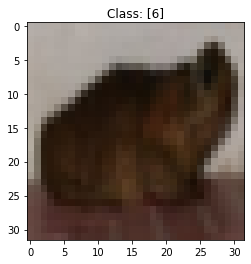

Text(0.5, 1.0, 'Class: [6]')

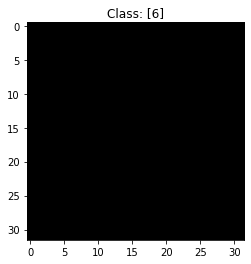

In [11]:
# Deze cel laat een willekeurige foto zien en de bijbehorende klasse.
randomindex = random.randint(0,len(X_test_augmented))
print(type(X_test_augmented[randomindex]))
temp = X_test_augmented[randomindex]
temp /= 255
# print(X_test[randomindex])
plt.imshow(X_test[randomindex])
plt.title("Class: {}".format(Y_train_labels[randomindex]))
plt.show()
plt.imshow(X_test_augmented[randomindex])
plt.title("Class: {}".format(Y_train_labels[randomindex])) # where(Y_train == max([randomindex]))

# Stap 3 - Stel het model op
Nu gaan we het model opstellen. Voor het opstellen van een convolutionair netwerk en/of neuraal netwerk bestaan heel veel bouwopties; er zijn zelfs al architecturen beschikbaar waarmee we ons netwerk kunnen opstellen. (https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)

We zijn hier vooral geinteresseerd in twee architecturen uit de gegeven bron die we willen uitwerken;
- LeNet-5 (1998)
- Alexnet (2018)

Tenslotte sluiten we af met een aanpak zoals we die kennen vanuit de theorie; een netwerk die opgesteld is aan de hand van drie patronen:
- Convolutionairy Layer met ReLU
- Convolutionairy Layer met ReLU & Maxpooling (afsluiten naar FCL's met Flatten())
- Fully connected layers met ReLU

Legenda:
![title](images/Legenda-1.png)

LeNet-5:
![title](images/LeNet-5.png)

Alexnet:
![title](images/Alexnet.png)

We gaan eerst gebruik maken van het architectuur van LeNet-5. Aangezien dit een best wel oud architectuur is, verwachten we wat tegenvallende resultaten.

# LeNet-5
LeNet-5 maakt gebruik van wat andere technieken dan dat we gekend zijn; er wordt gebruik gemaakt van AveragePooling (hierbij wordt van een pool per cluster het gemiddelde berekend en teruggegeven, bron: https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer ) en van tanh in plaats van de ReLU die we juist heel vaak terug zien in convolutionaire netwerken.

LeNet-5 begint met tweemaal een conv layer met een kernel van 5x5 en een averagepool, waarna hij direct overgaat naar drie fully connected layers.

In [12]:
model = Sequential()

Voor het gemak pakken we er 32 filters bij. Dit zullen we doen voor alle lagen in ons netwerk, maar soms wijken we er vanaf; dan hebben we namelijk al veel patronen 'herkend' en is er minder te leren.

In [13]:
model.add(Conv2D(32,kernel_size=(5,5),input_shape=(32,32,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation("tanh"))
model.add(AveragePooling2D(pool_size=(2,2)))

In [14]:
model.add(Conv2D(8,kernel_size=(5,5),input_shape=(32,32,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation("tanh"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())

In [15]:
model.add(Dense(120))
model.add(BatchNormalization(axis=-1))
model.add(Activation("tanh"))

In [16]:
model.add(Dense(84))
model.add(BatchNormalization(axis=-1))
model.add(Activation("tanh"))

In [17]:
model.add(Dense(10))
model.add(BatchNormalization(axis=-1))
model.add(Activation("softmax"))

We compilen het model met de categorial_crossentropy loss functie; deze berekent de loss uit voor targets waarbij het aantal classificaties meer dan 2 telt. Verder gebruiken we als optimizer adam.

In [18]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [19]:
outcome01 = model.fit(X_train,Y_train,batch_size=10,epochs=10,validation_split=0.2)

Epoch 1/10
4000/4000 [==============================] - 41s 10ms/step - loss: 1.8096 - accuracy: 0.3522 - val_loss: 2.0930 - val_accuracy: 0.2938
Epoch 2/10
4000/4000 [==============================] - 44s 11ms/step - loss: 1.5976 - accuracy: 0.4247 - val_loss: 1.7760 - val_accuracy: 0.3709
Epoch 3/10
4000/4000 [==============================] - 48s 12ms/step - loss: 1.5136 - accuracy: 0.4531 - val_loss: 1.3530 - val_accuracy: 0.5231
Epoch 4/10
4000/4000 [==============================] - 47s 12ms/step - loss: 1.4640 - accuracy: 0.4735 - val_loss: 1.3103 - val_accuracy: 0.5353
Epoch 5/10
4000/4000 [==============================] - 49s 12ms/step - loss: 1.4202 - accuracy: 0.4910 - val_loss: 1.5388 - val_accuracy: 0.4608
Epoch 6/10
4000/4000 [==============================] - 50s 13ms/step - loss: 1.3843 - accuracy: 0.5045 - val_loss: 1.4158 - val_accuracy: 0.4935
Epoch 7/10
4000/4000 [==============================] - 53s 13ms/step - loss: 1.3491 - accuracy: 0.5191 - val_loss: 1.2460 -

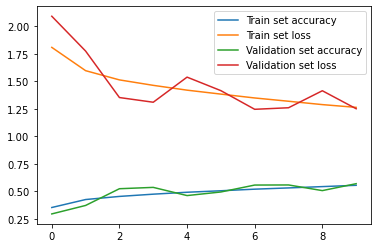

In [20]:
plt.plot(outcome01.history['accuracy'],label="Train set accuracy")
plt.plot(outcome01.history['loss'],label="Train set loss")
plt.plot(outcome01.history['val_accuracy'],label="Validation set accuracy")
plt.plot(outcome01.history['val_loss'],label="Validation set loss")
plt.legend()

In [21]:
outcome02 = model.evaluate(X_test,Y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.2494 - accuracy: 0.5660


# Alexnet

Alexnet is in tegenstelling tot LeNet-5 een stuk zwaarder; deze kent grotere filters en aan het eind van de convolutionele layers wordt in successie 3 keer een convolution layer toegepast van 3x3. Bovendien wordt hier gebruik gemaakt van max-pool en van ReLU, waarmee we verwachten dat onze uitkomsten beter zullen zijn.

In [22]:
model2 = Sequential()

Het alexnet architectuur begint met een convolutionaire layer van 11x11. Dit zou wel voor een input zijn van 224x224x3. De derde dimensie klopt, maar we zullen ietsje moeten sjoemelen met de filter-size, willen we dit architectuur überhaupt gebruiken in de eerste plaats voor een input van 32x32x3

In [23]:
# Convolutionaire Layer 1
model2.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))
model2.add(BatchNormalization(axis=-1))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

In [24]:
# Convolutionaire Layer 2
model2.add(Conv2D(32,kernel_size=(3,3)))
model2.add(BatchNormalization(axis=-1))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

En dan gebeurt er iets geks; in dit architectuur wordt een convolutionaire layer 3 keer achter elkaar opgezet zonder er eerst een maxpool bij te doen.

In [25]:
# Convolutionaire Layer 3
model2.add(Conv2D(3,kernel_size=(3,3)))
model2.add(BatchNormalization(axis=-1))
model2.add(Activation("relu"))

In [26]:
# Convolutionaire Layer 4
model2.add(Conv2D(3,kernel_size=(2,2)))
model2.add(BatchNormalization(axis=-1))
model2.add(Activation("relu"))

In [27]:
# Convolutionaire Layer 5
model2.add(Conv2D(3,kernel_size=(2,2)))
model2.add(BatchNormalization(axis=-1))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())

In [28]:
# Fully connected Layer 6
model2.add(Dense(4096))
model2.add(Dropout(0.2))
model2.add(Activation("relu"))
model2.add(BatchNormalization(axis=-1))

In [29]:
# Fully connected Layer 7
model2.add(Dense(256))
model2.add(Dropout(0.2))
model2.add(Activation("relu"))
model2.add(BatchNormalization(axis=-1))

In [30]:
# Fully connected Layer 8
model2.add(Dense(10))
model2.add(Dropout(0.2))
model2.add(Activation("softmax"))

In [31]:
model2.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [32]:
outcome21 = model2.fit(X_train,Y_train,epochs=10,batch_size=40,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 60s 60ms/step - loss: 2.3094 - accuracy: 0.1742 - val_loss: 1.9360 - val_accuracy: 0.2505
Epoch 2/10
1000/1000 [==============================] - 60s 60ms/step - loss: 1.9957 - accuracy: 0.2505 - val_loss: 1.9622 - val_accuracy: 0.2799
Epoch 3/10
1000/1000 [==============================] - 62s 62ms/step - loss: 1.8959 - accuracy: 0.2952 - val_loss: 2.0875 - val_accuracy: 0.2931
Epoch 4/10
1000/1000 [==============================] - 59s 59ms/step - loss: 1.8055 - accuracy: 0.3332 - val_loss: 1.9814 - val_accuracy: 0.3063
Epoch 5/10
1000/1000 [==============================] - 62s 62ms/step - loss: 1.7332 - accuracy: 0.3597 - val_loss: 1.6304 - val_accuracy: 0.3917
Epoch 6/10
1000/1000 [==============================] - 61s 61ms/step - loss: 1.6862 - accuracy: 0.3738 - val_loss: 1.6507 - val_accuracy: 0.3631
Epoch 7/10
1000/1000 [==============================] - 61s 61ms/step - loss: 1.6541 - accuracy: 0.3847 - val_loss: 1.5481 -

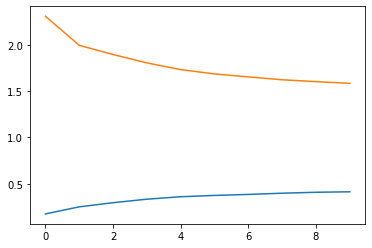

In [33]:
# outcome.history.keys()
plt.plot(outcome21.history['accuracy'],label="Train set accuracy")
plt.plot(outcome21.history['loss'],label="Train set loss")

In [34]:
outcome22 = model2.evaluate(X_test,Y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.4952 - accuracy: 0.4350


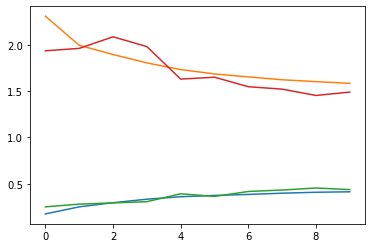

In [35]:
plt.plot(outcome21.history['accuracy'],label="Train set accuracy")
plt.plot(outcome21.history['loss'],label="Train set loss")
plt.plot(outcome21.history['val_accuracy'],label="Validation set accuracy")
plt.plot(outcome21.history['val_loss'],label="Validation set loss")

Ook hier zien we weer dat het netwerk niet echt goed werkt. Dit heeft te maken met dat het gegeven architectuur wat we proberen na te volgen gemaakt is voor plaatsjes van formaat 224x224x3. We zullen dus zelf met een soort variant moeten komen van het eerste netwerk om een optimale score te verkrijgen.

# Gerrit's Voorstel
Het architectuur van LeNet-5 komt aardig dicht in de buurt van wat we uiteindelijk willen hebben. Deze gebruikt alleen nog niet de perfect methodes. Door andere methodes toe te passen (MaxPool i.p.v. AveragePool, ReLU i.p.v. tanh, Patterns voor de convolutionairy layers) willen we de nauwkeurigheid van dit structuur verbeteren.

We beginnen in principe altijd met een Sequential model.

In [50]:
model3 = Sequential()

Daarna willen we convolutionary layer(s) gaan toevoegen; dat is waar een convolutionary network überhaupt mee begint. Onze eerste convolutionary layer hoort te werken met de input; een shape van 32x32x3; dus 3 filters en (in overeenkomst met ons architectuur) een filtergrootte van 5x5.

In [51]:
# Convolutionary Layer 1
model3.add(Conv2D(32,kernel_size=(5,5),input_shape=(32,32,3)))  # Van 32x32 naar 27x27
model3.add(BatchNormalization(axis=-1))  # In principe altijd normaliseren!
model3.add(Activation("relu"))

Dan nog één keer hetzelfde blok. Dit is het laatste blok voordat we in het daadwerkelijke neurale netwerk terecht komen; daarvoor willen we gebruik maken van een Flatten zodat het er in past.

In [52]:
# Convolutionary Layer 2
model3.add(Conv2D(32,kernel_size=(5,5),input_shape=(32,32,3)))  # Van 27x27 naar 22x22
model3.add(BatchNormalization(axis=-1))  # In principe altijd normaliseren!
model3.add(Activation("relu"))

In [53]:
# Convolutionary Layer 3
model3.add(Conv2D(32,kernel_size=(3,3)))  # Van 22x22 naar 20x20 
model3.add(BatchNormalization(axis=-1))  # In principe altijd normaliseren!
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))  # Van 20x20 naar 10x10

In [54]:
# Convolutionary Layer 3
model3.add(Conv2D(32,kernel_size=(3,3),input_shape=(32,32,3)))  # Van 10x10 naar 8x8
model3.add(BatchNormalization(axis=-1))  # In principe altijd normaliseren!
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))  # Van 8x8 naar 4x4 
model3.add(Flatten())

Nu gaan we over op het neurale netwerk wat hier aan vast zit. Dit zijn 3 layers met verschillende units en activatiefuncties.

In [55]:
# Fully connected layer 3
model3.add(Dense(60))
model3.add(Dropout(0.2))
model3.add(Activation("relu"))

In [56]:
# Fully connected layer 4
model3.add(Dense(20))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Activation("relu"))

In [57]:
# Fully connected layer 5 (final)
model3.add(Dense(10))
model3.add(Dropout(0.2))
model3.add(Activation("softmax"))

Ons netwerk is nu klaar, we kunnen hem nu gaan compilen en daarna fitten en evalueren. Als loss gebruiken we hier "categorial_crossentropy"; deze rekent de error uit als je meer dan twee labels hebt, en als optimizer gebruiken we Adam.

In [58]:
model3.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [59]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        25632     
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 32)       

En dan gaan we nu het model meteen fitten. We gebruiken 20 epochs en een batch_size van 10.

In [60]:
outcome11 = model3.fit(X_train,Y_train,batch_size=10,epochs=20,validation_split=0.2)

Epoch 1/20
4000/4000 [==============================] - 145s 36ms/step - loss: 1.9531 - accuracy: 0.2896 - val_loss: 1.7141 - val_accuracy: 0.3702
Epoch 2/20
4000/4000 [==============================] - 162s 41ms/step - loss: 1.7184 - accuracy: 0.3869 - val_loss: 1.5024 - val_accuracy: 0.4652
Epoch 3/20
4000/4000 [==============================] - 204s 51ms/step - loss: 1.6006 - accuracy: 0.4317 - val_loss: 1.2754 - val_accuracy: 0.5510
Epoch 4/20
4000/4000 [==============================] - 205s 51ms/step - loss: 1.5170 - accuracy: 0.4647 - val_loss: 1.2271 - val_accuracy: 0.5692
Epoch 5/20
4000/4000 [==============================] - 207s 52ms/step - loss: 1.4583 - accuracy: 0.4923 - val_loss: 1.0939 - val_accuracy: 0.6166
Epoch 6/20
4000/4000 [==============================] - 225s 56ms/step - loss: 1.4088 - accuracy: 0.5073 - val_loss: 1.0363 - val_accuracy: 0.6442
Epoch 7/20
4000/4000 [==============================] - 212s 53ms/step - loss: 1.3665 - accuracy: 0.5250 - val_loss: 1

# Stap 4 - Evalueren
We doen het evalueren op basis van het vergelijken van de loss en de nauwkeurigheid met de trainingsset, en daarna ook nog met de validatieset (die tijdens het fitten is opgesteld)

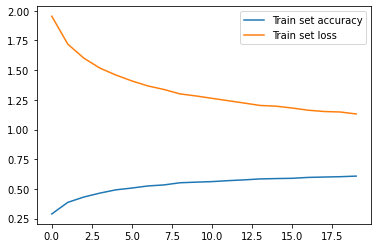

In [61]:
# outcome.history.keys()
plt.plot(outcome11.history['accuracy'],label="Train set accuracy")
plt.plot(outcome11.history['loss'],label="Train set loss")
plt.legend()

In [62]:
outcome12 = model3.evaluate(X_test,Y_test)

313/313 [==============================] - 6s 19ms/step - loss: 0.8606 - accuracy: 0.7100


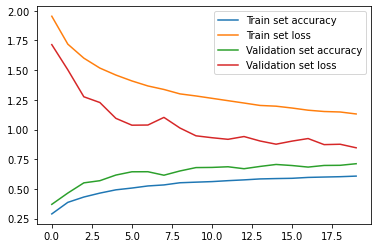

In [63]:
outcome11.history.keys()
plt.plot(outcome11.history['accuracy'],label="Train set accuracy")
plt.plot(outcome11.history['loss'],label="Train set loss")
plt.plot(outcome11.history['val_accuracy'],label="Validation set accuracy")
plt.plot(outcome11.history['val_loss'],label="Validation set loss")
plt.legend()

Met onze aanpassingen zijn we toch op een mooie accuracy van rond de 71 % terecht gekomen, wat in mijn opinie al best wel goed is voor een netwerk zonder verder toegepaste trucjes (zoals l1l2 regularization, andere optimizers, e.d.). Bovendien ziet het er naar uit dat ons netwerk niet overfit is; er zijn wel wat onregelmatigheden te zien in de laatste plot, maar aanzich niks extreems. Bovendien komt de loss en nauwkeurigheid van het toepassen van ons model op de testset enigszins overeen met de nauwkeurigheid en de loss op de validatieset.

Text(0.5, 1.0, 'Class: [5], Predicted: [5]')

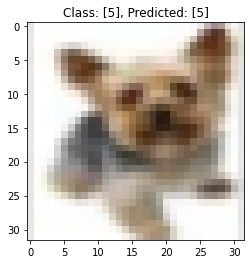

In [143]:
# Deze cel pakt de voorspelling van een netwerkt en checkt het plaatje wat daarbij hoort.
randomindex = random.randrange(len(X_train))
outcome = model3.predict(X_train[randomindex].reshape(1,32,32,3))
classoutcome = np.where(outcome[0] == max(outcome[0]))
classoutcome[0][0]
plt.imshow(X_train[randomindex])
plt.title("Class: {}, Predicted: {}".format(Y_train_labels[randomindex],classoutcome[0]))